<h2 style="text-align: center; font-family: Arial, sans-serif; font-weight: bold; color: #2c3e50; text-transform: uppercase; margin: 20px 0;">Smart Vehicle Damage Detection</h2>

#### Importing all Libraries

In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

<h3 style="font-family: Arial, sans-serif; color: #34495e; margin: 15px 0; text-transform: uppercase; letter-spacing: 1px;">Data Load and Transformation</h3>

In [2]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  #These values are calculated per channel (Red, Green, Blue) and are derived from the ImageNet training dataset
])

In [3]:
dataset_path = "./dataset"

dataset = datasets.ImageFolder(root=dataset_path, transform=image_transforms)
len(dataset)

2300

In [4]:
class_names = dataset.classes
class_names # 6 classes for the output

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [5]:
num_classes = len(dataset.classes)
num_classes

6

#### Splitting the Data: 75% Training, 25% Testing

In [6]:
train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size

train_size, val_size

(1725, 575)

In [7]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [9]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [21]:
labels[8]  # F_Breakage

tensor(0)

In [22]:
images[8].shape

torch.Size([3, 224, 224])

In [23]:
images[8].permute(1,2,0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..2.64].


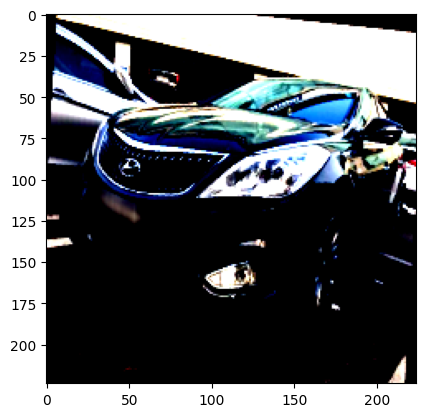

In [24]:
plt.imshow(images[8].permute(1,2,0))
plt.show()

<h3 style="font-family: Arial, sans-serif; color: #34495e; margin: 15px 0; text-transform: uppercase; letter-spacing: 1px;">model 1: cnn</h3>

In [25]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)           
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [27]:
images.size(0)

32

In [28]:
len(train_loader.dataset)

1725

In [13]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")
            
            running_loss += loss.item() * images.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
            
    end = time.time()
    print(f"Execution time: {end - start} seconds")     
    
    return all_labels, all_predictions

In [32]:
# Instantiate the model, loss function, and optimizer
model = CarClassifierCNN(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.75
Batch: 20, Epoch: 1, Loss: 1.65
Batch: 30, Epoch: 1, Loss: 1.74
Batch: 40, Epoch: 1, Loss: 1.57
Batch: 50, Epoch: 1, Loss: 1.24
Epoch [1/10], Avg Loss: 1.7335
*** Validation Accuracy: 48.17% ***
Batch: 10, Epoch: 2, Loss: 1.24
Batch: 20, Epoch: 2, Loss: 0.94
Batch: 30, Epoch: 2, Loss: 1.08
Batch: 40, Epoch: 2, Loss: 1.40
Batch: 50, Epoch: 2, Loss: 1.27
Epoch [2/10], Avg Loss: 1.2279
*** Validation Accuracy: 50.43% ***
Batch: 10, Epoch: 3, Loss: 1.20
Batch: 20, Epoch: 3, Loss: 1.21
Batch: 30, Epoch: 3, Loss: 0.90
Batch: 40, Epoch: 3, Loss: 1.10
Batch: 50, Epoch: 3, Loss: 1.03
Epoch [3/10], Avg Loss: 1.0876
*** Validation Accuracy: 56.00% ***
Batch: 10, Epoch: 4, Loss: 0.85
Batch: 20, Epoch: 4, Loss: 0.83
Batch: 30, Epoch: 4, Loss: 1.05
Batch: 40, Epoch: 4, Loss: 1.18
Batch: 50, Epoch: 4, Loss: 1.23
Epoch [4/10], Avg Loss: 0.9976
*** Validation Accuracy: 57.74% ***
Batch: 10, Epoch: 5, Loss: 0.79
Batch: 20, Epoch: 5, Loss: 0.93
Batch: 30, Epoch: 5, Loss: 0

#### Insights: 
The plane model achieves a validation accuracy of 61.22%

<h3 style="font-family: Arial, sans-serif; color: #34495e; margin: 15px 0; text-transform: uppercase; letter-spacing: 1px;">model 2: cnn with regularization</h3>

In [33]:
class CarClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.BatchNorm2d(16),   # Added Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),   # Added Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)           
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),   # Added Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),   # Added Dropout Regularization(50%)
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [34]:
model = CarClassifierCNNWithRegularization(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)   # Added L2 Regularization

all_labels, all_predictions = train_model(model, criterion, optimizer,  epochs=10)

Batch: 10, Epoch: 1, Loss: 13.08
Batch: 20, Epoch: 1, Loss: 5.55
Batch: 30, Epoch: 1, Loss: 1.62
Batch: 40, Epoch: 1, Loss: 1.48
Batch: 50, Epoch: 1, Loss: 1.48
Epoch [1/10], Avg Loss: 7.7416
*** Validation Accuracy: 40.35% ***
Batch: 10, Epoch: 2, Loss: 1.28
Batch: 20, Epoch: 2, Loss: 1.87
Batch: 30, Epoch: 2, Loss: 1.28
Batch: 40, Epoch: 2, Loss: 1.20
Batch: 50, Epoch: 2, Loss: 1.79
Epoch [2/10], Avg Loss: 1.4452
*** Validation Accuracy: 48.00% ***
Batch: 10, Epoch: 3, Loss: 1.12
Batch: 20, Epoch: 3, Loss: 1.51
Batch: 30, Epoch: 3, Loss: 1.23
Batch: 40, Epoch: 3, Loss: 1.22
Batch: 50, Epoch: 3, Loss: 1.38
Epoch [3/10], Avg Loss: 1.3313
*** Validation Accuracy: 52.17% ***
Batch: 10, Epoch: 4, Loss: 1.50
Batch: 20, Epoch: 4, Loss: 1.32
Batch: 30, Epoch: 4, Loss: 1.37
Batch: 40, Epoch: 4, Loss: 0.93
Batch: 50, Epoch: 4, Loss: 1.05
Epoch [4/10], Avg Loss: 1.2516
*** Validation Accuracy: 50.26% ***
Batch: 10, Epoch: 5, Loss: 1.42
Batch: 20, Epoch: 5, Loss: 1.34
Batch: 30, Epoch: 5, Loss: 

#### Insights: 
The model with Regularizations(Batch-Normalization, Dropout, L2) achieves a validation accuracy of 56.00%, a decrease from the plain model's 61.22%,

<h3 style="font-family: Arial, sans-serif; color: #34495e; margin: 15px 0; text-transform: uppercase; letter-spacing: 1px;">model 3: Transfer Learning with EfficientNet</h3>

In [35]:
model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1].in_features

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\RAKESH KAPILAVAI/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|█████████████████████████████████████████████████████████████████████████████| 20.5M/20.5M [00:00<00:00, 35.2MB/s]


1280

In [13]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        in_features = self.model.classifier[1].in_features
        
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x              

In [37]:
model = CarClassifierEfficientNet(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.57
Batch: 20, Epoch: 1, Loss: 1.53
Batch: 30, Epoch: 1, Loss: 1.44
Batch: 40, Epoch: 1, Loss: 1.52
Batch: 50, Epoch: 1, Loss: 1.28
Epoch [1/10], Avg Loss: 1.4918
*** Validation Accuracy: 57.22% ***
Batch: 10, Epoch: 2, Loss: 1.11
Batch: 20, Epoch: 2, Loss: 1.18
Batch: 30, Epoch: 2, Loss: 1.07
Batch: 40, Epoch: 2, Loss: 1.10
Batch: 50, Epoch: 2, Loss: 0.93
Epoch [2/10], Avg Loss: 1.1514
*** Validation Accuracy: 63.48% ***
Batch: 10, Epoch: 3, Loss: 1.09
Batch: 20, Epoch: 3, Loss: 1.13
Batch: 30, Epoch: 3, Loss: 1.21
Batch: 40, Epoch: 3, Loss: 1.07
Batch: 50, Epoch: 3, Loss: 1.05
Epoch [3/10], Avg Loss: 1.0337
*** Validation Accuracy: 66.61% ***
Batch: 10, Epoch: 4, Loss: 1.00
Batch: 20, Epoch: 4, Loss: 0.67
Batch: 30, Epoch: 4, Loss: 1.00
Batch: 40, Epoch: 4, Loss: 0.99
Batch: 50, Epoch: 4, Loss: 1.01
Epoch [4/10], Avg Loss: 0.9539
*** Validation Accuracy: 68.52% ***
Batch: 10, Epoch: 5, Loss: 0.75
Batch: 20, Epoch: 5, Loss: 0.87
Batch: 30, Epoch: 5, Loss: 0

#### Insights: 
The transfer learning model built with EfficientNet has achieved a validation accuracy of 71.13%, indicating improved performance but potential for further optimization.

<h3 style="font-family: Arial, sans-serif; color: #34495e; margin: 15px 0; text-transform: uppercase; letter-spacing: 1px;">model 4: Transfer Learning with ResNet</h3>

In [11]:
# Load the pre-trained ResNet model
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True            
            
        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [39]:
model = CarClassifierResNet(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\RAKESH KAPILAVAI/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:02<00:00, 48.9MB/s]


Batch: 10, Epoch: 1, Loss: 0.94
Batch: 20, Epoch: 1, Loss: 0.55
Batch: 30, Epoch: 1, Loss: 0.64
Batch: 40, Epoch: 1, Loss: 0.91
Batch: 50, Epoch: 1, Loss: 0.64
Epoch [1/10], Avg Loss: 0.9022
*** Validation Accuracy: 73.22% ***
Batch: 10, Epoch: 2, Loss: 0.32
Batch: 20, Epoch: 2, Loss: 0.79
Batch: 30, Epoch: 2, Loss: 0.62
Batch: 40, Epoch: 2, Loss: 0.52
Batch: 50, Epoch: 2, Loss: 0.43
Epoch [2/10], Avg Loss: 0.4803
*** Validation Accuracy: 75.83% ***
Batch: 10, Epoch: 3, Loss: 0.21
Batch: 20, Epoch: 3, Loss: 0.50
Batch: 30, Epoch: 3, Loss: 0.11
Batch: 40, Epoch: 3, Loss: 0.30
Batch: 50, Epoch: 3, Loss: 0.38
Epoch [3/10], Avg Loss: 0.3453
*** Validation Accuracy: 78.43% ***
Batch: 10, Epoch: 4, Loss: 0.36
Batch: 20, Epoch: 4, Loss: 0.32
Batch: 30, Epoch: 4, Loss: 0.06
Batch: 40, Epoch: 4, Loss: 0.09
Batch: 50, Epoch: 4, Loss: 0.30
Epoch [4/10], Avg Loss: 0.2344
*** Validation Accuracy: 77.39% ***
Batch: 10, Epoch: 5, Loss: 0.24
Batch: 20, Epoch: 5, Loss: 0.10
Batch: 30, Epoch: 5, Loss: 0

#### Insights: 
The highest validation accuracy achieved across all models is 77.74%, obtained using transfer learning with ResNet, indicating progress with potential for further improvement.

#### I ran hyperparameter tunning in another notebook and figured that the best parameters for resnet models are (1) Dropout rate = 0.2 (2) Learning Rate = 0.005

So now let's train the model once again with these best parameters

In [14]:
model = CarClassifierResNet(num_classes=num_classes, dropout_rate=0.2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.005)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.45
Batch: 20, Epoch: 1, Loss: 0.66
Batch: 30, Epoch: 1, Loss: 0.75
Batch: 40, Epoch: 1, Loss: 0.68
Batch: 50, Epoch: 1, Loss: 0.42
Epoch [1/10], Avg Loss: 0.8991
*** Validation Accuracy: 73.22% ***
Batch: 10, Epoch: 2, Loss: 0.58
Batch: 20, Epoch: 2, Loss: 0.64
Batch: 30, Epoch: 2, Loss: 0.24
Batch: 40, Epoch: 2, Loss: 0.55
Batch: 50, Epoch: 2, Loss: 0.53
Epoch [2/10], Avg Loss: 0.5178
*** Validation Accuracy: 73.57% ***
Batch: 10, Epoch: 3, Loss: 0.27
Batch: 20, Epoch: 3, Loss: 0.26
Batch: 30, Epoch: 3, Loss: 0.13
Batch: 40, Epoch: 3, Loss: 0.33
Batch: 50, Epoch: 3, Loss: 0.29
Epoch [3/10], Avg Loss: 0.3587
*** Validation Accuracy: 77.39% ***
Batch: 10, Epoch: 4, Loss: 0.31
Batch: 20, Epoch: 4, Loss: 0.23
Batch: 30, Epoch: 4, Loss: 0.34
Batch: 40, Epoch: 4, Loss: 0.27
Batch: 50, Epoch: 4, Loss: 0.38
Epoch [4/10], Avg Loss: 0.2761
*** Validation Accuracy: 77.22% ***
Batch: 10, Epoch: 5, Loss: 0.15
Batch: 20, Epoch: 5, Loss: 0.07
Batch: 30, Epoch: 5, Loss: 0

### Model Evaluation using Confusion Matrix and Classification Report

In [15]:
from sklearn.metrics import classification_report

report = classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.78      0.83       106
           1       0.67      0.91      0.77       103
           2       0.99      0.81      0.89       129
           3       0.84      0.63      0.72        86
           4       0.58      0.64      0.61        77
           5       0.71      0.84      0.77        74

    accuracy                           0.78       575
   macro avg       0.78      0.77      0.77       575
weighted avg       0.80      0.78      0.78       575



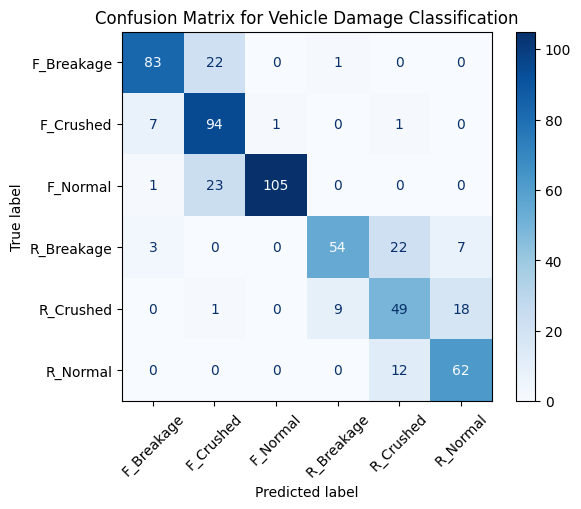

In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(labels, predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

#### Insights:
- Model is strong at classifying front-side damage, especially F_Normal and F_Breakage.

- Rear-side classification is weaker; especially distinguishing between R_Normal and R_Crushed.

### Save the Model

In [17]:
torch.save(model.state_dict(), 'saved_model.pth')